### Income and Outlays Monthly Data

In [1]:
%config Completer.use_jedi = False
import sys
import json
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

### Download NIPA tables

In [2]:
# Request data from BEA API
for tbl in ['20600', '20806', '20804']:
    r = bea_api_nipa([f'T{tbl}'], bea_key, freq='M')
    s = nipa_series_codes(json.loads(r[0][2])['BEAAPI']['Results'])
    data = json.loads(r[0][2])['BEAAPI']['Results']
    date = lambda x: pd.to_datetime(x.TimePeriod.str.replace('M', '-') + '-01')
    df = pd.DataFrame({c: (pd.DataFrame(data['Data']).assign(date = date)
                             .query('SeriesCode == @c')
                             .set_index('date')['DataValue'].sort_index())
                       for c in s.keys()}).replace(',','', regex=True).astype(float)
    df.to_csv(data_dir / f'nipa{tbl}.csv', index_label='date')

### Income measures per capita

In [3]:
s = ['A261RC', 'A262RC']
df = nipa_df(retrieve_table('T11000')['Data'], s).sort_index()
df['NDI'] = (df['A261RC'] - df['A262RC'])

# deflator
pce = pd.read_csv(data_dir / 'nipa20804.csv', 
                 index_col='date', parse_dates=True)['DPCERG']
pce = (pce.iloc[-1] / pce)
pceq = pce.resample('QS').mean()

# DPI and PI, monthly, and population
cols = ['A067RC', 'A065RC', 'B230RC']
dfm = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                  parse_dates=True)[cols])
pop = dfm['B230RC']
popq = dfm['B230RC'].resample('QS').mean()

# Per capita real monthly
d = {'A065RC': 'PI', 'A067RC': 'DPI'}
pcm = (dfm[d.keys()].divide(pop, axis=0).multiply(pce, axis=0)
       .rename(d, axis=1)).rolling(3).mean()

#pcm.to_csv(data_dir / 'pc_inc_mon.csv', index_label='date')
# Per capita real quarterly
pcq = ((df['NDI'] / popq) * pceq).dropna()
pcq.name = 'NDI'
pcq.index = pcq.index + pd.DateOffset(days=45)
#pcq.to_csv(data_dir / 'pc_inc_qtr.csv', index_label='date')

### After-tax income growth

In [4]:
df = pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                 parse_dates=True)
data = (df['A229RX'].pct_change(12) * 100).dropna()
data.to_csv(data_dir / 'rdpigrowth.csv', header=['rdpi'], 
            index_label='date')
color = 'blue!80!cyan'
node = end_node(data, color, date='m', percent=True)
write_txt(text_dir / 'rdpi_node.txt', node)

ltdate = dtxt(data.index[-1])['mon1']
ltval = data.iloc[-1]
prdate = dtxt(data.index[-2])['mon1']
prval = data.iloc[-2]
prdate2 = dtxt(data.index[-13])['mon1']
prval2 = data.iloc[-13]
ltavg = data.iloc[-13:].mean()
ltavg2 = data.loc['2017-03-01': '2020-02-01'].mean()
url = 'https://www.bea.gov/data/income-saving/personal-income'
text = (f'The Bureau of Economic Analysis \href{{{url}}}{{report}} '+
        'an inflation-adjusted one-year change in after-tax income '+
        f'per person of {ltval:.1f} percent in {ltdate}, {prval:.1f} '+
        f'percent in {prdate}, and {prval2:.1f} percent in '+
        f'{prdate2} {c_line(color)}. Over the past year, the measure '+
        f'has averaged {ltavg:.1f} percent. During the three years '+
        'before the COVID-19 pandemic, per capita after-tax income '+
        f'grew at an average annual rate of {ltavg2:.1f} percent.')
write_txt(text_dir / 'rdpigrowth.txt', text)
print(text)

The Bureau of Economic Analysis \href{https://www.bea.gov/data/income-saving/personal-income}{report} an inflation-adjusted one-year change in after-tax income per person of 3.3 percent in July 2023, 4.3 percent in June 2023, and -4.9 percent in July 2022 (see {\color{blue!80!cyan}\textbf{---}}). Over the past year, the measure has averaged 0.2 percent. During the three years before the COVID-19 pandemic, per capita after-tax income grew at an average annual rate of 2.6 percent.


### Monthly consumer spending growth

In [5]:
pop = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                  parse_dates=True)['B230RC'])
pce = (pd.read_csv(data_dir/'nipa20806.csv', index_col='date', 
                  parse_dates=True)['DPCERX'])
npce = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                  parse_dates=True)['DPCERC'])
df = ((pce / pop).pct_change(12) * 100).dropna().rename('rpcepop')
hist = pd.read_csv('../data/rpcepop_hist.csv', index_col='DATE', 
                   parse_dates=True)['rpcepop']
df = pd.concat([hist, df])
df.to_csv(data_dir / 'pcegrowth.csv', index_label='date')
color = 'green!70!olive!60!black'
node = end_node(df, color, date='m', percent=True)
write_txt(text_dir / 'pcegrowth_node.txt', node)

ltdt = dtxt(df.index[-1])['mon1']
ltpc = f'\${(npce / pop).iloc[-1] * 1000:,.0f} per capita'
ltval  = df.iloc[-1]
pydate = dtxt(df.index[-13])['mon1']
pyval = df.iloc[-13]
compare = compare_text(ltval, pyval, [0.1, 0.5, 2.0])
url = 'https://www.bea.gov/data/consumer-spending/main'
pyrt = value_text(pyval, 'increase_of', threshold=0.1)
ltrt = value_text(ltval, threshold=0.1)

text = (f'Consumer spending is also \href{{{url}}}{{reported}}'+
        f' on a monthly basis. In {ltdt}, consumer spending totals '+
        f'{ltpc}, on an annualized basis. Inflation- and population-'+
        f'adjusted consumer spending {ltrt} over the year ending {ltdt} '+
        f'{c_line(color)}, {compare} the previous year rate ({pyrt} '+
        f'over the year ending {pydate}). ')
write_txt(text_dir / 'pcegrowth.txt', text)
print(text)

Consumer spending is also \href{https://www.bea.gov/data/consumer-spending/main}{reported} on a monthly basis. In July 2023, consumer spending totals \$55,270 per capita, on an annualized basis. Inflation- and population-adjusted consumer spending increased 2.5 percent over the year ending July 2023 (see {\color{green!70!olive!60!black}\textbf{---}}), substantially above the previous year rate (an increase of 1.8 percent over the year ending July 2022). 


### Personal saving rate

In [6]:
df = pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                 parse_dates=True)
data = df.loc['1989':, 'A072RC']
data.to_csv(data_dir / 'psavert.csv', index_label='date')
datelt = dtxt(data.index[-1])['mon1']
latest = data.iloc[-1]
ch_covid = latest - data.loc['2020-02-01']
color = 'red'
node = end_node(data, color, date='m', percent=True, 
                offset=0.35)
write_txt(text_dir / 'psavert_node.txt', node)

txt = value_text(ch_covid, ptype='pp', adj='total')
url = 'https://www.bea.gov/data/income-saving/personal-saving-rate'
text = (f'In {datelt}, the Bureau of Economic Analysis '+
        f'\href{{{url}}}{{report}} a personal saving rate of '+
        f'{latest:.1f} percent {c_line(color)}. '+
        f'The personal saving rate {txt} since February 2020.')
write_txt(text_dir / 'psavert.txt', text)
print(text)

In July 2023, the Bureau of Economic Analysis \href{https://www.bea.gov/data/income-saving/personal-saving-rate}{report} a personal saving rate of 3.5 percent (see {\color{red}\textbf{---}}). The personal saving rate decreased by a total of 5.8 percentage points since February 2020.


### Personal Income

In [7]:
series = {
 'TOTAL': '\hspace{2mm}Personal income',
 'LABOR': '\hspace{-1mm}\cbox{green!75!black} Labor',
 'A034RC': '\hspace{4mm} Wages and salaries',
 'A038RC': '\hspace{4mm} Supplements',
 'CAPITAL': '\hspace{-1mm}\cbox{orange!40!yellow}Capital',
 'A041RC': "\hspace{4mm} Proprietors' income",
 'A048RC': '\hspace{4mm} Rental income',
 'A064RC': '\hspace{4mm} Personal interest income',
 'B703RC': '\hspace{4mm} Personal dividend income',
 'TRANSFER': '\hspace{-1mm}\cbox{blue!80!white}Welfare',
 'W823RC': '\hspace{4mm} Social security',
 'W824RC': '\hspace{4mm} Medicare',
 'W729RC': '\hspace{4mm} Medicaid',
 'W825RC': '\hspace{4mm} Unemployment insurance',
 'W826RC': "\hspace{4mm} Veterans' benefits",
 'W827RC': '\hspace{4mm} Other',
 'A061RC': '\hspace{4mm} Less welfare contributions'}

In [8]:
df = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                 parse_dates=True)        
        .assign(CAPITAL = lambda x: x['A041RC'] + x['A048RC'] + x['W210RC'],
                TRANSFER = lambda x: x['A577RC'] - x['A061RC'],
                A061RC = lambda x: - x['A061RC'])
        .rename({'A065RC': 'TOTAL', 'A033RC': 'LABOR'}, axis=1))
df.to_csv(data_dir / 'pi_raw.csv', index_label='date')

In [9]:
df = pd.read_csv(data_dir / 'pi_raw.csv', index_col='date', parse_dates=True)

pce = pd.read_csv(data_dir / 'nipa20804.csv', 
                 index_col='date', parse_dates=True)['DPCERG']
pce = (pce.iloc[-1] / pce)

pop = df['B230RC']

data = (df.div(pop, axis=0).multiply(pce, axis=0))
cols = ['LABOR', 'CAPITAL', 'TRANSFER']
(data.loc['1989-01-01':,cols]
     .to_csv(data_dir / 'pi_levels.csv', index_label='date'))

tbl = ((data[series.keys()].rename(series, axis=1)
            .iloc[[-1, -2, -3, -4, -13, -37]].T * 1000)
            .applymap('{:,.0f}'.format))

tbl.columns = [dtxt(c)['mon6'] for c in tbl.columns]
tbl.index.name = ''
tbl.iloc[0, 0] = f'\${tbl.iloc[0, 0]}'
tbl.to_csv(data_dir / 'pi_levels.tex', sep='&', 
           lineterminator='\\\ ', quotechar=' ')

ld = data.index[-1]
ltdate = dtxt(data.index[-1])['mon1']
totval = data.loc[ld, 'TOTAL'] * 1000
labval = data.loc[ld, 'LABOR'] * 1000
capval = data.loc[ld, 'CAPITAL'] * 1000
welval = data.loc[ld, 'TRANSFER'] * 1000
text = (f'In {ltdate}, annualized personal income is '+
        f'\${totval:,.0f} per capita. Labor income totals \${labval:,.0f} '+
        f'per person; capital and proprietor income is \${capval:,.0f} '+
        f'per person; and welfare or transfer income is \${welval:,.0f} '+
        'per person. ')
write_txt(text_dir / 'pi_levels_basic.txt', text)
write_txt(text_dir / 'pi_date.txt', ltdate)
print(text)

In July 2023, annualized personal income is \$68,195 per capita. Labor income totals \$42,634 per person; capital and proprietor income is \$18,743 per person; and welfare or transfer income is \$6,818 per person. 


### Income, Outlays, Savings overview

In [10]:
# Income outlays and savings, overview
series2 = {'A067RC': 'DPI',
           'DPCERC': 'PCE',
           'A071RC': 'PSAVE'}
df2 = data.loc['1989':].rename(series2, axis=1)[series2.values()]
df2.to_csv(data_dir / 'inc_out_save.csv', index_label='date')

ltdate = dtxt(df2.index[-1])['mon1']
value = df['A067RC'].iloc[-1] / 1_000_000
value = f'\${value:.1f} trillion'
valuepc = df2['DPI'].iloc[-1] * 1000
valuepc = f'\${valuepc:,.0f}'
pcevalue = df['DPCERC'].iloc[-1] / 1_000_000
pcevalue = f'\${pcevalue:.1f} trillion'
pcevaluepc = df2['PCE'].iloc[-1] * 1000
pcevaluepc = f'\${pcevaluepc:,.0f}'
savevalue = df['A071RC'].iloc[-1] / 1_000_000
savevalue = f'\${savevalue:.1f} trillion'
savevaluepc = df2['PSAVE'].iloc[-1] * 1000
savevaluepc = f'\${savevaluepc:,.0f}'

text = ('Disposable personal income, or \\textbf{after-tax income}, '+
        f'totals {value}, on an annualized basis, in {ltdate}, '+
        f'equivalent to {valuepc} per person '+
        '(see {\color{blue!75!black}\\textbf{---}}). Personal '+
        f'consumption expenditures, or \\textbf{{consumer spending}}, totals '+
        f'{pcevalue} in {ltdate}, or {pcevaluepc} per person '+
        '(see {\color{orange}\\textbf{---}}). \\textbf{Saving}, '+
        'calculated as after-tax income minus consumer spending, '+
        f'totals {savevalue}, or {savevaluepc} per person '+
        '(see {\color{green!80!blue}\\textbf{---}}). ')
write_txt(text_dir / 'inc_out_save.txt', text)
print(text)

series3 = {
 'TOTAL': '\hspace{1mm}Personal Income',
 'W055RC': '\hspace{4mm}Personal Current Taxes',
 'A067RC': '\hspace{-1mm} {\color{blue!75!black}\\textbf{---}} \ After-Tax Income',
 'DPCERC': '\hspace{1mm} {\color{orange}\\textbf{---}} \ Consumer Spending',
 'A071RC': '\hspace{1mm} {\color{green!80!blue}\\textbf{---}} \ Personal Saving'}

tbl = ((data[series3.keys()].rename(series3, axis=1)
            .iloc[[-1, -2, -3, -4, -13, -37]].T * 1000)
            .applymap('{:,.0f}'.format))

tbl.columns = [dtxt(c)['mon6'] for c in tbl.columns]
tbl.index.name = ''
tbl.iloc[0, 0] = f'\${tbl.iloc[0, 0]}'
tbl.to_csv(data_dir / 'inc_out_save_levels.tex', sep='&', 
           lineterminator='\\\ ', quotechar=' ')

Disposable personal income, or \textbf{after-tax income}, totals \$20.0 trillion, on an annualized basis, in July 2023, equivalent to \$59,553 per person (see {\color{blue!75!black}\textbf{---}}). Personal consumption expenditures, or \textbf{consumer spending}, totals \$18.5 trillion in July 2023, or \$55,270 per person (see {\color{orange}\textbf{---}}). \textbf{Saving}, calculated as after-tax income minus consumer spending, totals \$0.7 trillion, or \$2,104 per person (see {\color{green!80!blue}\textbf{---}}). 


### Detailed information on spending by type

In [11]:
years = ','.join(map(str, range(1988, 2024)))
url = (f'https://apps.bea.gov/api/data/?&UserID={bea_key}'+
        '&method=GetData&datasetname=NIUnderlyingDetail&'+
        'TableName=U20405&Frequency=M&'+
       f'Year={years}&ResultFormat=json')
r = requests.get(url).json()
data = pd.DataFrame(r['BEAAPI']['Results']['Data'])
data['DataValue'] = data['DataValue'].str.replace(',', '').astype('int')
df = data.groupby(['TimePeriod', 'SeriesCode'])['DataValue'].mean().unstack()
df.columns.name = ''
df.index = (df.reset_index().TimePeriod
            .apply(lambda x: pd.to_datetime(x, format='%YM%m')).rename('date'))
df.to_csv(data_dir / 'nipaU20405.csv')

### Gross Labor Income

In [12]:
# Calculate Gross Labor Income
start = '2017-01-01'
coe = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                   parse_dates=True)['A033RC']
       .pct_change(12) * 100).rename('BEA')
coe.loc[start:].to_csv(data_dir / 'gli_coe.csv', index_label='date')

# Text
cline = c_line('orange!80!yellow')
ltdt = dtxt(coe.index[-1])['mon1']
prdt = dtxt(coe.index[-13])['mon1']
text = (f'The monthly data on compensation of employees from BEA {cline} '+
        f'shows one-year gross labor income growth of {coe.iloc[-1]:.1f} '+
        f'percent in {ltdt}, and {coe.iloc[-13]:.1f} percent in '+
        f'{prdt}, one-year prior. ')
write_txt(text_dir / 'gli_coe.txt', text)
print(text)

The monthly data on compensation of employees from BEA (see {\color{orange!80!yellow}\textbf{---}}) shows one-year gross labor income growth of 4.7 percent in July 2023, and 8.3 percent in July 2022, one-year prior. 


### Social Security

In [55]:
data = pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                 parse_dates=True)
df = data[['W823RC', 'A034RC', 'A061RC', 'W824RC']]

<AxesSubplot: xlabel='date'>

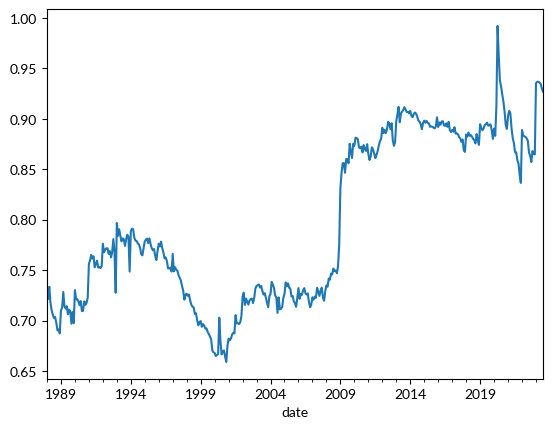

In [63]:
#Payments share of wages
(df['W823RC'] / (df['A034RC'] * 0.124)).plot()

<AxesSubplot: xlabel='date'>

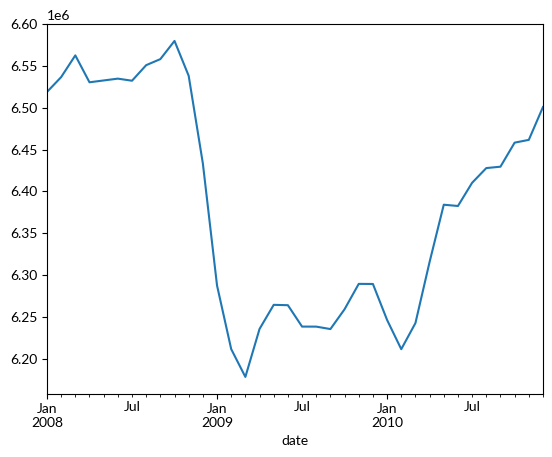

In [66]:
df.loc['2008': '2010', 'A034RC'].plot()

In [69]:
df.loc['2009-01-01', 'W823RC']

648062.0

In [75]:
((df.loc['2008-08-01', 'A034RC'] - df.loc['2009-03-01', 'A034RC']) * 0.124) / df.loc['2009-03-01', 'W823RC']

0.07053439878954088

<AxesSubplot: xlabel='date'>

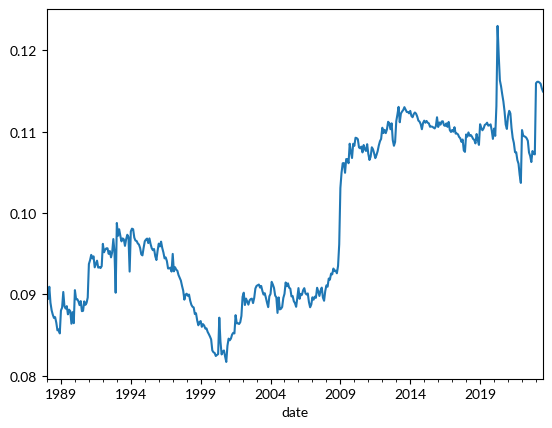

In [49]:
#Payments share of wages
(df['W823RC'] / df['A034RC']).plot()

<AxesSubplot: xlabel='date'>

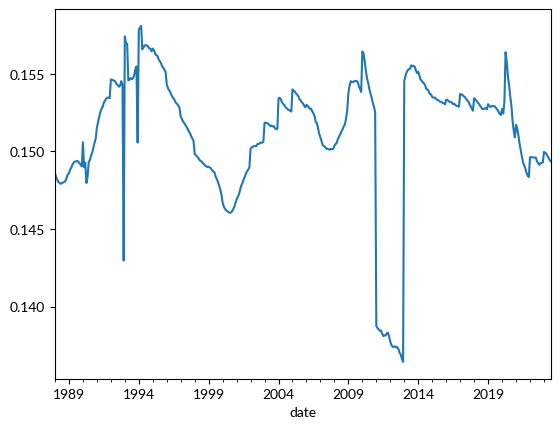

In [50]:
# Payroll taxes share of wages
(df['A061RC'] / df['A034RC']).plot()

<AxesSubplot: xlabel='date'>

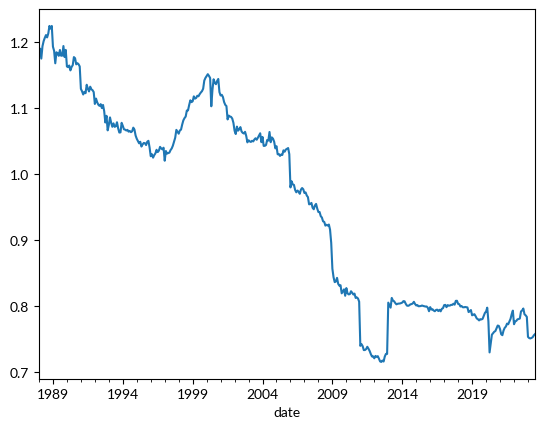

In [56]:
# Payroll taxes share of social security and medicare payments
(df['A061RC'] / (df['W823RC'] + df['W824RC'])).plot()

### Personal Income and Net Domestic Income

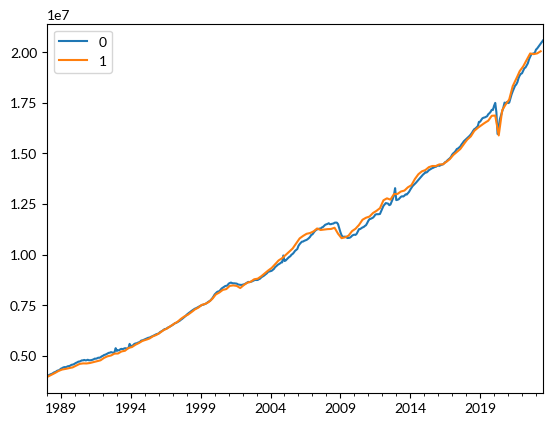

In [27]:
df = pd.read_csv(data_dir / 'pi_raw.csv', index_col='date', 
                 parse_dates=True)
df.index = df.index.to_period('M')
mpi = df[['LABOR', 'CAPITAL']].sum(axis=1)
labsh = df['LABOR'] / mpi

s = ['A261RC', 'A4002C', 'A262RC', 'W056RC', 'A107RC']
df = nipa_df(retrieve_table('T11000')['Data'], s).sort_index()
df.index = (df.index + pd.DateOffset(days=45)).to_period('M')
# Calculate indirect taxes net of transfers
df['indirect'] = df['W056RC'] - df['A107RC']
# Income minus depreciation and indirect taxes
ndi = (df['A261RC'] - df['A262RC'] - df['indirect'])
ndi = ndi.resample('M').interpolate()
pd.concat([mpi, ndi], axis=1).plot();

In [44]:
labsh2 = df['A4002C'].resample('M').interpolate() / ndi
pd.concat([labsh, labsh2], axis=1).plot()

TypeError: 'NoneType' object is not subscriptable